In [133]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [134]:
import pandas as pd

retail = pd.read_csv("OnlineRetail_invoice.csv")
retail.head()

,InvoiceNo,InvoiceDate,TTL_price,CustomerID
0,536365,01-12-2010 08:26,27.37,17850.0
1,536366,01-12-2010 08:28,3.70,17850.0
2,536367,01-12-2010 08:34,58.24,13047.0
3,536368,01-12-2010 08:34,19.10,13047.0
4,536369,01-12-2010 08:35,5.95,13047.0


In [135]:
retail.shape

(25900, 4)

In [136]:
retail.describe()

,TTL_price,CustomerID
count,25900.000000,22190.000000
mean,96.478918,15238.498738
std,494.677787,1733.149624
min,-11062.060000,12346.000000
25%,7.410000,13755.000000
50%,31.130000,15136.000000
75%,75.665000,16746.000000
max,38970.000000,18287.000000


# Data Cleaning：移除資料中缺失值

In [137]:
# 检查DataFrame中的缺失值
missing_values = retail.isna().sum()
print(missing_values)

InvoiceNo         0
InvoiceDate       0
TTL_price         0
CustomerID     3710
dtype: int64


In [138]:
# 删除包含缺失值的列
retail.dropna(inplace=True)

# 删除包含缺失值的行
#df.dropna(axis=1, inplace=True)

In [139]:
missing_values = retail.isna().sum()
print(missing_values)

InvoiceNo      0
InvoiceDate    0
TTL_price      0
CustomerID     0
dtype: int64


In [140]:
retail.shape 

(22190, 4)

In [141]:
column_types = retail.dtypes
print(column_types)

InvoiceNo       object
InvoiceDate     object
TTL_price      float64
CustomerID     float64
dtype: object


In [142]:
# 將 customer_id converted to object
retail['CustomerID'] = retail['CustomerID'].astype(object)


column_types = retail.dtypes
print(column_types)

InvoiceNo       object
InvoiceDate     object
TTL_price      float64
CustomerID      object
dtype: object


# Data Preparation

In [143]:
import pandas as pd


# New Attribute : Monetary
rfm_m = retail.groupby('CustomerID')['TTL_price'].sum().reset_index()
rfm_m = rfm_m.rename(columns={'TTL_price':'Monetary'})
rfm_m.head()


,CustomerID,Monetary
0,12346.0,2.08
1,12347.0,481.21
2,12348.0,178.71
3,12349.0,605.10
4,12350.0,65.30


In [144]:
# New Attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [145]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Monetary,Frequency
0,12346.0,2.08,2
1,12347.0,481.21,7
2,12348.0,178.71,4
3,12349.0,605.10,1
4,12350.0,65.30,1


In [146]:
# New Attribute : Recency

# Convert to datetime to proper datatype
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

# Compute the maximum date to know the last transaction date
max_date = max(retail['InvoiceDate'])
max_date

# Compute the difference between max date and transaction date
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,InvoiceDate,TTL_price,CustomerID,Diff
0,536365,2010-12-01 08:26:00,27.37,17850.0,373 days 04:24:00
1,536366,2010-12-01 08:28:00,3.70,17850.0,373 days 04:22:00
2,536367,2010-12-01 08:34:00,58.24,13047.0,373 days 04:16:00
3,536368,2010-12-01 08:34:00,19.10,13047.0,373 days 04:16:00
4,536369,2010-12-01 08:35:00,5.95,13047.0,373 days 04:15:00


In [147]:
# Compute last transaction date to get the recency of customers
rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()

# Extract number of days only
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [148]:
# Merge tha dataframes to get the final RFM dataframe
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Monetary', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,2.08,2,325
1,12347.0,481.21,7,1
2,12348.0,178.71,4,74
3,12349.0,605.10,1,18
4,12350.0,65.30,1,309


In [149]:
# 使用 Pandas 的 loc 方法查找特定 Customer ID 的记录
customer_data = retail.loc[retail['CustomerID'] == 12347.0]

# 打印查找到的记录
print(customer_data)

      InvoiceNo         InvoiceDate  TTL_price CustomerID              Diff
647      537626 2010-12-07 14:57:00      89.59    12347.0 366 days 21:53:00
2651     542237 2011-01-26 14:30:00      73.17    12347.0 316 days 22:20:00
6112     549222 2011-04-07 10:43:00      62.29    12347.0 246 days 02:07:00
9616     556201 2011-06-09 13:01:00      53.62    12347.0 182 days 23:49:00
12492    562032 2011-08-02 08:48:00      68.24    12347.0 129 days 04:02:00
18114    573511 2011-10-31 12:25:00     120.76    12347.0  39 days 00:25:00
21859    581180 2011-12-07 15:52:00      13.54    12347.0   1 days 20:58:00


/var/folders/32/17fwcjcd1kv9vkdd_3w2k4vw0000gn/T/ipykernel_28846/3096713537.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, cmap='viridis', marker='o')


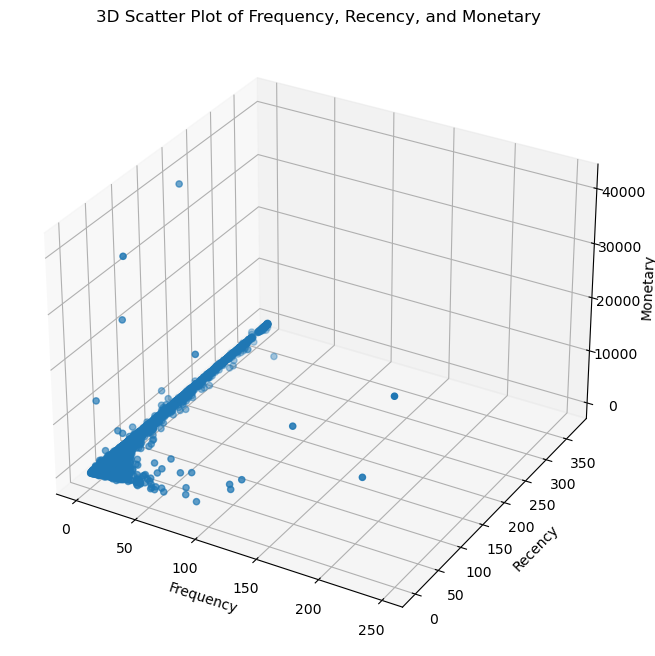

In [150]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 創建一個3D圖形
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 繪制三維散點圖，其中x、y、z分別代表三個特徵
x = rfm['Frequency']
y = rfm['Recency']
z = rfm['Monetary']
#c = rfm['Cluster_Id']  # 使用顏色表示簇

#scatter = ax.scatter(x, y, z, c=c, cmap='viridis', marker='o')
scatter = ax.scatter(x, y, z, cmap='viridis', marker='o')

# 添加軸標籤
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary')

# 添加標題
ax.set_title('3D Scatter Plot of Frequency, Recency, and Monetary')

# 定義三個顏色
#colors = ['red', 'green', 'blue']

# 添加顏色條
#cbar = fig.colorbar(scatter)
#cbar.set_ticks([0, 1, 2])  # 設置顏色刻度
#cbar.set_ticklabels(['Red', 'Green', 'Blue'])  # 設置顏色標籤


# 顯示圖形
plt.show()

# Building the Model : DBSCAN

# raw

In [151]:
#  model 
dbscan = DBSCAN(eps=0.5, min_samples=5)  
dbscan.fit(rfm)

DBSCAN()

In [152]:
dbscan.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [153]:
# assign the label
rfm['Cluster_Id'] = dbscan.labels_
rfm.head()

,CustomerID,Monetary,Frequency,Recency,Cluster_Id
0,12346.0,2.08,2,325,-1
1,12347.0,481.21,7,1,-1
2,12348.0,178.71,4,74,-1
3,12349.0,605.10,1,18,-1
4,12350.0,65.30,1,309,-1


In [154]:
# 顯示統計各label數量
value_counts = rfm['Cluster_Id'] .value_counts()
print(value_counts)

-1    4372
Name: Cluster_Id, dtype: int64


# 標準化

In [155]:
# Rescaling the attributes

rfm_df = rfm[['Monetary', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled

array([[-0.2490419 , -0.32936215,  2.32202285],
       [ 0.12392752,  0.20610242, -0.89373323],
       [-0.11154771, -0.11517632, -0.1691956 ],
       ...,
       [-0.20186901, -0.22226923, -0.83418219],
       [ 0.69974815,  1.16993863, -0.87388289],
       [-0.16927612, -0.22226923, -0.48680114]])

In [156]:
rfm_df_scaled.shape

(4372, 3)

In [157]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Monetary', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Monetary,Frequency,Recency
0,-0.249042,-0.329362,2.322023
1,0.123928,0.206102,-0.893733
2,-0.111548,-0.115176,-0.169196
3,0.220367,-0.436455,-0.725005
4,-0.199830,-0.436455,2.163220


In [158]:
#  model 
dbscan2 = DBSCAN(eps=0.5, min_samples=5)  
dbscan2.fit(rfm_df_scaled)

DBSCAN()

In [159]:
dbscan2.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [160]:
# assign the label
rfm['Cluster_Id'] = dbscan2.labels_
rfm.head()

,CustomerID,Monetary,Frequency,Recency,Cluster_Id
0,12346.0,2.08,2,325,0
1,12347.0,481.21,7,1,0
2,12348.0,178.71,4,74,0
3,12349.0,605.10,1,18,0
4,12350.0,65.30,1,309,0


In [161]:
value_counts = rfm['Cluster_Id'] .value_counts()
print(value_counts)

 0    4323
-1      39
 1       5
 2       5
Name: Cluster_Id, dtype: int64


# 正規化

In [162]:
from sklearn.preprocessing import MinMaxScaler


rfm_df_normalization = rfm[['Monetary', 'Frequency', 'Recency']]

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(rfm_df_normalization)
print(normalized_data.shape)



(4372, 3)


In [163]:
normalized_data = pd.DataFrame(normalized_data)
normalized_data.columns = ['Monetary', 'Frequency', 'Recency']
normalized_data.head()

,Monetary,Frequency,Recency
0,0.000050,0.004049,0.871314
1,0.011630,0.024291,0.002681
2,0.004319,0.012146,0.198391
3,0.014624,0.000000,0.048257
4,0.001578,0.000000,0.828418


In [164]:
#  model 
dbscan3 = DBSCAN(eps=0.5, min_samples=5)  
dbscan3.fit(normalized_data)

DBSCAN()

In [165]:
dbscan3.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [166]:
# assign the label
rfm['Cluster_Id'] = dbscan3.labels_
rfm.head()

,CustomerID,Monetary,Frequency,Recency,Cluster_Id
0,12346.0,2.08,2,325,0
1,12347.0,481.21,7,1,0
2,12348.0,178.71,4,74,0
3,12349.0,605.10,1,18,0
4,12350.0,65.30,1,309,0


In [167]:
value_counts = rfm['Cluster_Id'] .value_counts()
print(value_counts)

 0    4371
-1       1
Name: Cluster_Id, dtype: int64
